In [19]:
# example of training a gan on mnist
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
import matplotlib.pyplot as plt

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
# 	filename = 'generated_plot_e%03d.png' % (epoch+1)
# 	pyplot.savefig(filename)
# 	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [5]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

4/4 [==============================] - 0s 3ms/step
>1, 1/234, d=0.651, g=0.728
4/4 [==============================] - 0s 2ms/step
>1, 2/234, d=0.653, g=0.718
4/4 [==============================] - 0s 2ms/step
>1, 3/234, d=0.647, g=0.727
4/4 [==============================] - 0s 2ms/step
>1, 4/234, d=0.658, g=0.731
4/4 [==============================] - 0s 2ms/step
>1, 5/234, d=0.656, g=0.741
4/4 [==============================] - 0s 2ms/step
>1, 6/234, d=0.660, g=0.759
4/4 [==============================] - 0s 2ms/step
>1, 7/234, d=0.663, g=0.744
4/4 [==============================] - 0s 2ms/step
>1, 8/234, d=0.669, g=0.744
4/4 [==============================] - 0s 2ms/step
>1, 9/234, d=0.658, g=0.737
4/4 [==============================] - 0s 2ms/step
>1, 10/234, d=0.677, g=0.728
4/4 [==============================] - 0s 2ms/step
>1, 11/234, d=0.659, g=0.723
4/4 [==============================] - 0s 2ms/step
>1, 12/234, d=0.685, g=0.697
4/4 [==============================] - 0s 2ms/ste

4/4 [==============================] - 0s 2ms/step
>1, 204/234, d=0.692, g=0.695
4/4 [==============================] - 0s 2ms/step
>1, 205/234, d=0.679, g=0.693
4/4 [==============================] - 0s 2ms/step
>1, 206/234, d=0.690, g=0.684
4/4 [==============================] - 0s 2ms/step
>1, 207/234, d=0.685, g=0.695
4/4 [==============================] - 0s 2ms/step
>1, 208/234, d=0.703, g=0.724
4/4 [==============================] - 0s 2ms/step
>1, 209/234, d=0.692, g=0.719
4/4 [==============================] - 0s 2ms/step
>1, 210/234, d=0.685, g=0.730
4/4 [==============================] - 0s 2ms/step
>1, 211/234, d=0.683, g=0.731
4/4 [==============================] - 0s 2ms/step
>1, 212/234, d=0.685, g=0.727
4/4 [==============================] - 0s 2ms/step
>1, 213/234, d=0.677, g=0.720
4/4 [==============================] - 0s 2ms/step
>1, 214/234, d=0.686, g=0.721
4/4 [==============================] - 0s 2ms/step
>1, 215/234, d=0.689, g=0.727
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
>2, 173/234, d=0.701, g=0.731
4/4 [==============================] - 0s 2ms/step
>2, 174/234, d=0.702, g=0.719
4/4 [==============================] - 0s 2ms/step
>2, 175/234, d=0.697, g=0.694
4/4 [==============================] - 0s 2ms/step
>2, 176/234, d=0.700, g=0.671
4/4 [==============================] - 0s 2ms/step
>2, 177/234, d=0.694, g=0.677
4/4 [==============================] - 0s 2ms/step
>2, 178/234, d=0.697, g=0.670
4/4 [==============================] - 0s 2ms/step
>2, 179/234, d=0.690, g=0.676
4/4 [==============================] - 0s 2ms/step
>2, 180/234, d=0.690, g=0.667
4/4 [==============================] - 0s 2ms/step
>2, 181/234, d=0.693, g=0.688
4/4 [==============================] - 0s 2ms/step
>2, 182/234, d=0.693, g=0.704
4/4 [==============================] - 0s 2ms/step
>2, 183/234, d=0.679, g=0.708
4/4 [==============================] - 0s 2ms/step
>2, 184/234, d=0.683, g=0.712
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
>3, 41/234, d=0.670, g=0.756
4/4 [==============================] - 0s 2ms/step
>3, 42/234, d=0.674, g=0.768
4/4 [==============================] - 0s 3ms/step
>3, 43/234, d=0.674, g=0.756
4/4 [==============================] - 0s 2ms/step
>3, 44/234, d=0.660, g=0.739
4/4 [==============================] - 0s 2ms/step
>3, 45/234, d=0.683, g=0.708
4/4 [==============================] - 0s 2ms/step
>3, 46/234, d=0.678, g=0.704
4/4 [==============================] - 0s 2ms/step
>3, 47/234, d=0.684, g=0.689
4/4 [==============================] - 0s 2ms/step
>3, 48/234, d=0.680, g=0.690
4/4 [==============================] - 0s 2ms/step
>3, 49/234, d=0.678, g=0.690
4/4 [==============================] - 0s 2ms/step
>3, 50/234, d=0.687, g=0.692
4/4 [==============================] - 0s 2ms/step
>3, 51/234, d=0.684, g=0.677
4/4 [==============================] - 0s 2ms/step
>3, 52/234, d=0.698, g=0.700
4/4 [==============================] - 0

4/4 [==============================] - 0s 3ms/step
>3, 143/234, d=0.705, g=0.715
4/4 [==============================] - 0s 2ms/step
>3, 144/234, d=0.699, g=0.693
4/4 [==============================] - 0s 2ms/step
>3, 145/234, d=0.703, g=0.686
4/4 [==============================] - 0s 2ms/step
>3, 146/234, d=0.692, g=0.674
4/4 [==============================] - 0s 2ms/step
>3, 147/234, d=0.700, g=0.690
4/4 [==============================] - 0s 2ms/step
>3, 148/234, d=0.700, g=0.681
4/4 [==============================] - 0s 2ms/step
>3, 149/234, d=0.694, g=0.696
4/4 [==============================] - 0s 2ms/step
>3, 150/234, d=0.699, g=0.689
4/4 [==============================] - 0s 2ms/step
>3, 151/234, d=0.695, g=0.710
4/4 [==============================] - 0s 2ms/step
>3, 152/234, d=0.694, g=0.701
4/4 [==============================] - 0s 2ms/step
>3, 153/234, d=0.684, g=0.705
4/4 [==============================] - 0s 3ms/step
>3, 154/234, d=0.677, g=0.712
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
>4, 112/234, d=0.698, g=0.723
4/4 [==============================] - 0s 2ms/step
>4, 113/234, d=0.687, g=0.735
4/4 [==============================] - 0s 2ms/step
>4, 114/234, d=0.699, g=0.742
4/4 [==============================] - 0s 2ms/step
>4, 115/234, d=0.687, g=0.707
4/4 [==============================] - 0s 2ms/step
>4, 116/234, d=0.686, g=0.694
4/4 [==============================] - 0s 2ms/step
>4, 117/234, d=0.683, g=0.687
4/4 [==============================] - 0s 2ms/step
>4, 118/234, d=0.684, g=0.700
4/4 [==============================] - 0s 2ms/step
>4, 119/234, d=0.688, g=0.692
4/4 [==============================] - 0s 2ms/step
>4, 120/234, d=0.680, g=0.698
4/4 [==============================] - 0s 2ms/step
>4, 121/234, d=0.677, g=0.716
4/4 [==============================] - 0s 2ms/step
>4, 122/234, d=0.684, g=0.726
4/4 [==============================] - 0s 2ms/step
>4, 123/234, d=0.675, g=0.737
4/4 [=======================

4/4 [==============================] - 0s 2ms/step
>5, 81/234, d=0.679, g=0.735
4/4 [==============================] - 0s 3ms/step
>5, 82/234, d=0.679, g=0.728
4/4 [==============================] - 0s 2ms/step
>5, 83/234, d=0.679, g=0.758
4/4 [==============================] - 0s 2ms/step
>5, 84/234, d=0.665, g=0.760
4/4 [==============================] - 0s 2ms/step
>5, 85/234, d=0.677, g=0.758
4/4 [==============================] - 0s 2ms/step
>5, 86/234, d=0.681, g=0.729
4/4 [==============================] - 0s 2ms/step
>5, 87/234, d=0.673, g=0.713
4/4 [==============================] - 0s 3ms/step
>5, 88/234, d=0.678, g=0.699
4/4 [==============================] - 0s 2ms/step
>5, 89/234, d=0.687, g=0.696
4/4 [==============================] - 0s 2ms/step
>5, 90/234, d=0.681, g=0.692
4/4 [==============================] - 0s 2ms/step
>5, 91/234, d=0.692, g=0.687
4/4 [==============================] - 0s 2ms/step
>5, 92/234, d=0.687, g=0.707
4/4 [==============================] - 0

4/4 [==============================] - 0s 2ms/step
>6, 50/234, d=0.665, g=0.746
4/4 [==============================] - 0s 2ms/step
>6, 51/234, d=0.675, g=0.751
4/4 [==============================] - 0s 2ms/step
>6, 52/234, d=0.670, g=0.748
4/4 [==============================] - 0s 2ms/step
>6, 53/234, d=0.675, g=0.740
4/4 [==============================] - 0s 2ms/step
>6, 54/234, d=0.668, g=0.736
4/4 [==============================] - 0s 2ms/step
>6, 55/234, d=0.680, g=0.717
4/4 [==============================] - 0s 2ms/step
>6, 56/234, d=0.687, g=0.699
4/4 [==============================] - 0s 2ms/step
>6, 57/234, d=0.682, g=0.701
4/4 [==============================] - 0s 2ms/step
>6, 58/234, d=0.678, g=0.676
4/4 [==============================] - 0s 2ms/step
>6, 59/234, d=0.686, g=0.685
4/4 [==============================] - 0s 2ms/step
>6, 60/234, d=0.701, g=0.688
4/4 [==============================] - 0s 2ms/step
>6, 61/234, d=0.684, g=0.715
4/4 [==============================] - 0

KeyboardInterrupt: 

1/1 [==============================] - 0s 233ms/step


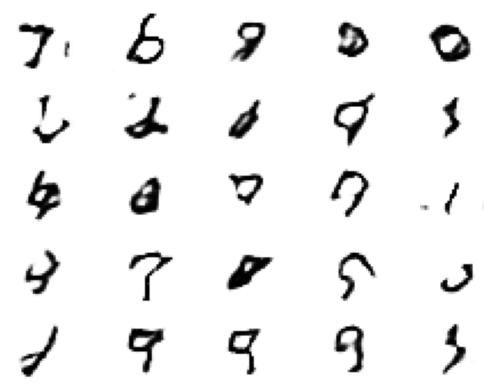

1/1 [==============================] - 0s 237ms/step


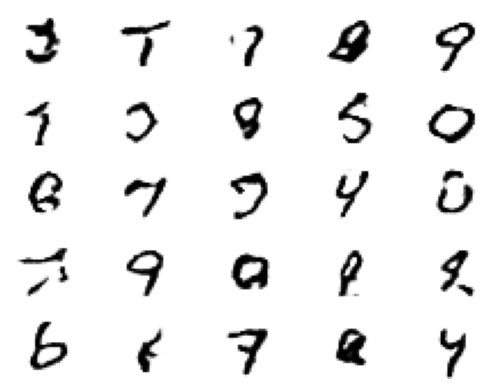

1/1 [==============================] - 0s 234ms/step


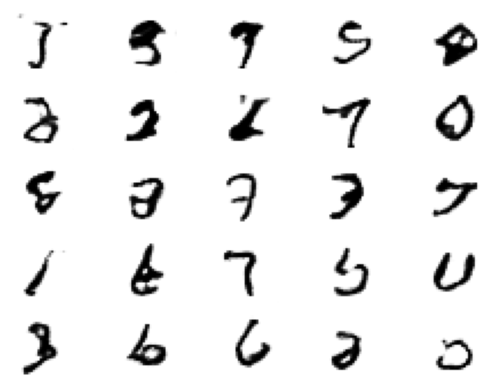

1/1 [==============================] - 0s 235ms/step


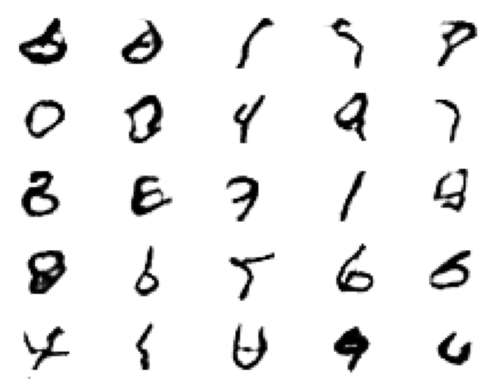

1/1 [==============================] - 0s 232ms/step


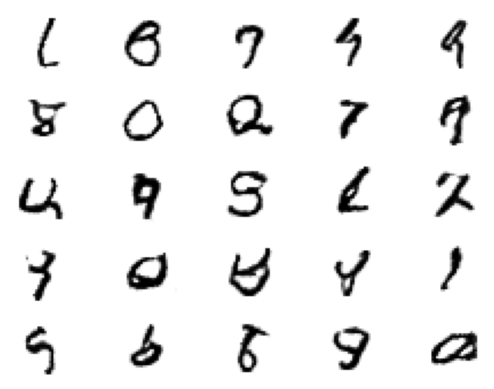

1/1 [==============================] - 0s 247ms/step


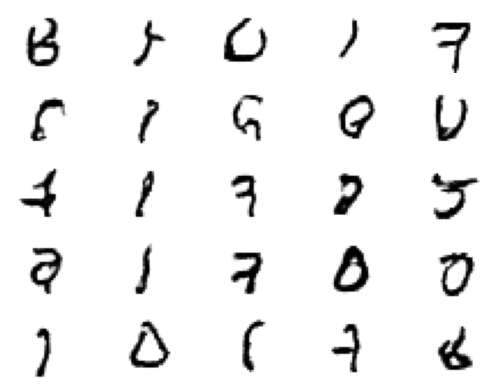

1/1 [==============================] - 0s 230ms/step


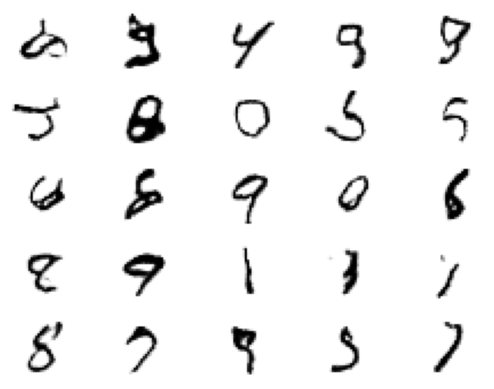

1/1 [==============================] - 0s 240ms/step


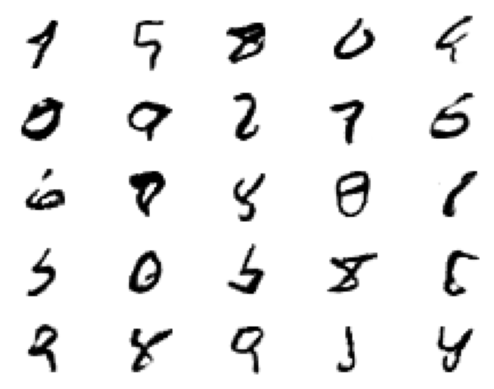

1/1 [==============================] - 0s 229ms/step


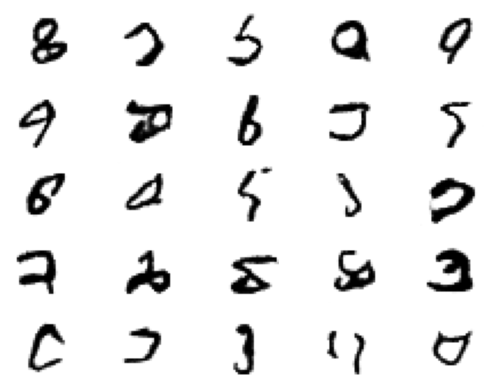

1/1 [==============================] - 0s 229ms/step


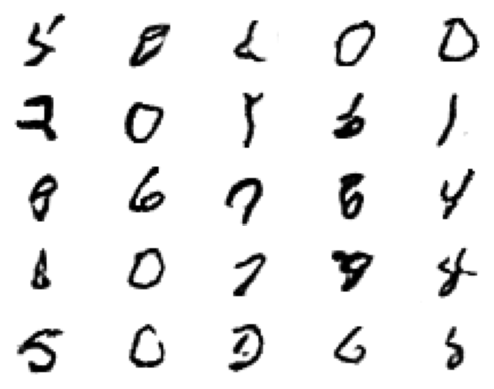

In [21]:
from tensorflow.keras.models import load_model
import os

def show_plot(examples, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    
for epoch in range(10, 110, 10):
    file_name = f'data/generator_model_{epoch:03d}.h5'    
    gen_10 = load_model(file_name)
    latent_points = generate_latent_points(100, 26)
    # generate images
    X = gen_10.predict(latent_points)
    show_plot(X, 5)
    plt.show()